- 学習データ増やす

In [9]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
%autoreload 2

import os
import sys
import json
import gc
import pickle 


from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

sys.path.append("../")
from src.model import MLModel, LightGBMModel
from src.validation import caluculate_metrics

# Config

In [11]:
class cfg:
    exp = "exp013"
    dataset_path = "../dataset/v5.0"
    feature_set = "small"
    valid_ratio = 0.2
    
    model_params = {
        "objective": "regression",
        "metric": "l2",
        "n_estimators": 2000,
        "max_depth": 5,
        "learning_rate": 0.01,
        "feature_fraction": 0.1,
        "seed": 42,
    }


In [12]:
# 実験用フォルダ作成    
os.makedirs(cfg.exp, exist_ok=True)

# 辞書形式に変換して保存 (推論時に使用する)
cfg_dict = {attr: getattr(cfg, attr) for attr in dir(cfg) if not attr.startswith("__") and not callable(getattr(cfg, attr))}
config_file = os.path.join(cfg.exp, "training_config.json")
with open(config_file, "w") as f:
    json.dump(cfg_dict, f, indent=4)

with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set]
print(f"feature col length: {len(feature_set)}")
targets = feature_metadata["targets"]


feature col length: 42


# Load Data

In [13]:
train = pd.read_parquet(
    f"{cfg.dataset_path}/train.parquet",
    columns=["era"] + feature_set + targets
)

valid = pd.read_parquet(
    f"{cfg.dataset_path}/validation.parquet",
    columns=["era"] + feature_set + targets
    
)

print(train.shape)
display(train.head(2))

print(valid.shape)
display(valid.head(2))

(2746270, 80)


,era,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,feature_donnard_groutier_twinkle,...,target_teager2b_60,target_tyler_20,target_tyler_60,target_victor_20,target_victor_60,target_waldo_20,target_waldo_60,target_xerxes_20,target_xerxes_60,target
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,2,2,2,2,2,0,1,2,2,...,0.5,0.25,0.25,0.25,0.25,0.25,0.00,0.25,0.00,0.25
n003bba8a98662e4,0001,2,2,2,2,2,1,4,2,2,...,0.5,0.25,0.25,0.25,0.00,0.25,0.25,0.25,0.25,0.25


(3577827, 80)


,era,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,feature_donnard_groutier_twinkle,...,target_teager2b_60,target_tyler_20,target_tyler_60,target_victor_20,target_victor_60,target_waldo_20,target_waldo_60,target_xerxes_20,target_xerxes_60,target
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,0,2,1,2,2,1,1,2,2,...,0.50,0.75,0.50,0.5,0.50,0.50,0.50,0.75,0.50,0.75
n001e1318d5072ac,0575,1,1,3,2,1,3,3,4,4,...,0.25,0.25,0.25,0.0,0.25,0.25,0.25,0.25,0.25,0.00


# Preprocess

In [14]:
# 学習データを増やす (train, valid を合体してから分ける)
print(train.shape, valid.shape)

data = pd.concat([train, valid])
display(data.tail())

n_idx = int(len(data) * (1 - cfg.valid_ratio))
print(data.shape)
print(n_idx)

train, valid = data.iloc[:n_idx], data.iloc[n_idx:]

print(train.shape, valid.shape)


(2746270, 80) (3577827, 80)


,era,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,feature_donnard_groutier_twinkle,...,target_teager2b_60,target_tyler_20,target_tyler_60,target_victor_20,target_victor_60,target_waldo_20,target_waldo_60,target_xerxes_20,target_xerxes_60,target
id,,,,,,,,,,,,,,,,,,,,,
nffce425c89dc5da,1153,0,0,2,2,4,2,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nffd4e7b55827375,1153,0,2,4,2,1,4,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nffea643830509bf,1153,0,3,1,1,3,4,3,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nffea66c53d0aebe,1153,1,2,0,1,2,2,1,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nfff2966f1f157af,1153,0,0,4,3,0,4,1,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(6324097, 80)
5059277
(5059277, 80) (1264820, 80)


In [15]:
# target が 20 日、 era が週次なので重複してる。ので era を間引く
train["era_int"] = train["era"].astype(int)
cond_train = train["era_int"] % 4 == 0
train = train.loc[cond_train]

/tmp/ipykernel_17057/308992532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["era_int"] = train["era"].astype(int)


# Training

In [16]:
features = feature_set
target = "target"

In [17]:
model = LightGBMModel(
    model_params=cfg.model_params,
)
model.train(
    train[features],
    train["target"],
    eval_set=(valid[features], valid["target"]),
    early_stopping_rounds=10
)

model.save_model(os.path.join(cfg.exp, "model.pkl"))

with open(os.path.join(cfg.exp, "feature.pkl"), "wb") as f:
     pickle.dump(features, f)

        
del train; gc.collect()

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1263218, number of used features: 42
[LightGBM] [Warning] Provided parameters con

17

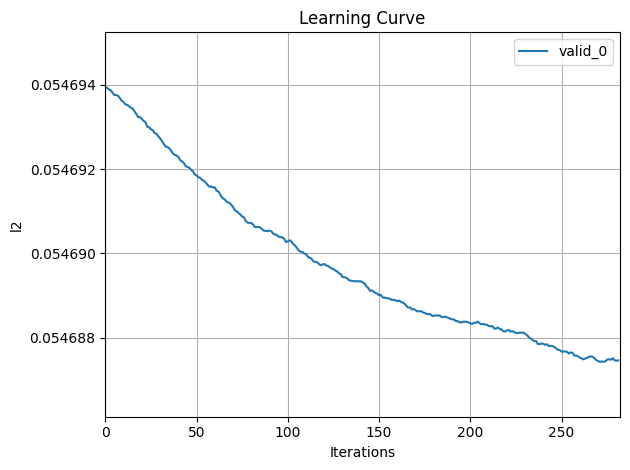

In [18]:
model.visualize_learning_curve()

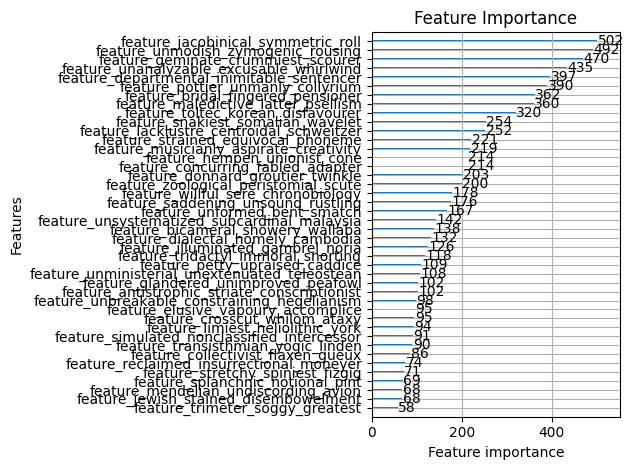

In [19]:
model.visualize_feature_importance()

# Validation

In [20]:
valid_pred = model.predict(valid[features])
valid["pred"] = valid_pred

/tmp/ipykernel_17057/3034019150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["pred"] = valid_pred


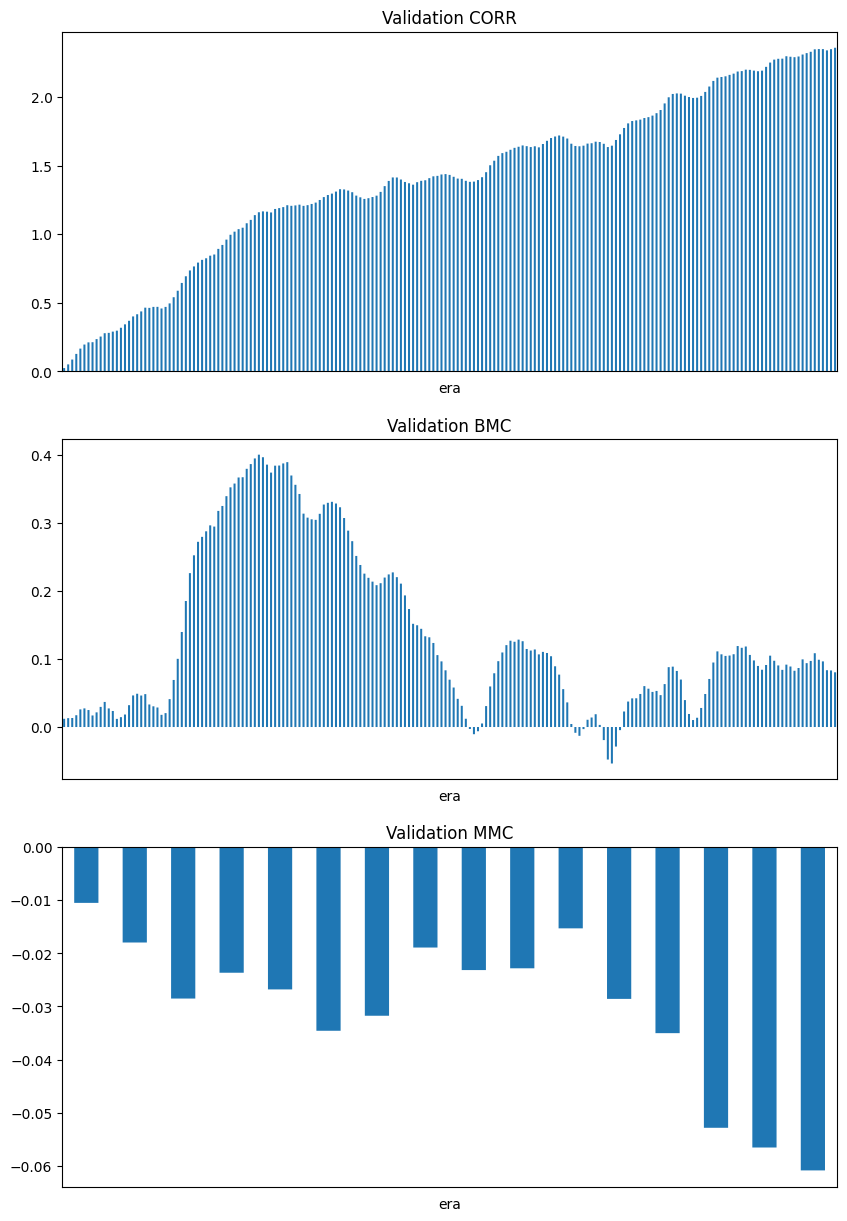

(   corr_mean  corr_std  corr_shape  corr_max_drawdown  mmc_mean   mmc_std  \
 0   0.012348  0.017011    0.725845           0.084372   -0.0038  0.007969   
 
    mmc_shape  mmc_max_drawdown  bmc_mean   bmc_std  bmc_shape  \
 0  -0.476907          0.050281  0.000421  0.013551   0.031047   
 
    bmc_max_drawdown  
 0          0.453543  ,
           pred
 era           
 0958  0.023504
 0959  0.026807
 0960  0.035345
 0961  0.041113
 0962  0.038555
 ...        ...
 1144  0.001928
 1145 -0.000276
 1146 -0.009269
 1147  0.008747
 1148  0.010302
 
 [191 rows x 1 columns],
           pred
 era           
 0958  0.012059
 0959  0.000955
 0960  0.000236
 0961  0.004067
 0962  0.008578
 ...        ...
 1144 -0.009558
 1145 -0.002426
 1146 -0.012939
 1147 -0.000392
 1148 -0.002702
 
 [191 rows x 1 columns],
           pred
 era           
 1133 -0.010525
 1134 -0.007446
 1135 -0.010534
 1136  0.004852
 1137 -0.003134
 1138 -0.007772
 1139  0.002823
 1140  0.012821
 1141 -0.004237
 1142  0.000333

In [21]:
caluculate_metrics(cfg.dataset_path, valid)